# Фильтр (оператор) Собеля 

**Описание оператора Собеля**

Оператор Собеля используется в области обработки изображений. Часто его применяют в алгоритмах выделения границ. По сути, это дискретный дифференциальный оператор, вычисляющий приближенное значение градиента яркости изображения. Результатом применения оператора Собеля в каждой точке изображения является либо вектор градиента яркости в этой точке, либо его норма. Оператор Собеля основан на свёртке изображения небольшими сепарабельными целочисленными фильтрами в вертикальном и горизонтальном направлениях, поэтому его относительно легко вычислять.

Математически, градиент функции двух переменных для каждой точки изображения (которой и является функция яркости) — двумерный вектор, компонентами которого являются производные яркости изображения по горизонтали и вертикали. В каждой точке изображения градиентный вектор ориентирован в направлении наибольшего увеличения яркости, а его длина соответствует величине изменения яркости. Это означает, что результатом оператора Собеля в точке области постоянной яркости будет нулевой вектор, а в точке, лежащей на границе областей различной яркости — вектор, пересекающий границу в направлении увеличения яркости.
**Формализация**

Оператор собеля использует ядра $3×3$, с которыми сворачивают исходное изображение для вычисления приближенных значений производных по горизонтали и по вертикали. Пусть $A$ исходное изображение, а $G_{x}$ и $G_{y}$ — два изображения, где каждая точка содержит приближенные производные по $x$ и по $y$. Они вычисляются следующим образом:

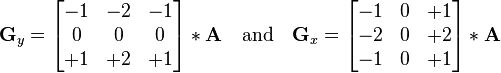,
где 
- $*$ - обозначает двумерную операцию свертки;

В каждой точке изображения приближенное значение величины градиента можно вычислить, используя полученные приближенные значения производных:
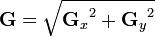



In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import math

Ниже представлена реализация оператора Собеля на языке python с использованием библиотеки openCV

***Параметры функции cv.Sobel():***

1. $src$ - изображение, которое необходимо обработать;
2. $ddepth$ - глубина выходного изображения. Мы установили для него значение **CV_16S**, чтобы избежать переполнения;
      Исходное изображение - $uint8$, 8-битное беззнаковое число, поэтому изображение, созданное Собелем, не имеет достаточного количества бит и будет усечено. То есть функция Собела будет иметь отрицательное значение после вычисления производной и значение больше 255. Поэтому используется 16-битный подписанный тип данных, а именно **cv2.CV_16S**.
3. $x_{order}$ - порядок производной в направлении $x$;
4. $y_{order}$ -  порядок производной в направлении $y$.

*Замечание:*

Обратите внимание, что для вычисления градиента в направлении $x$ мы используем $x_{order} = 1$, а $y_{order} = 0$. Для, вычисления градиента по $y$ параметры задаются аналогичным образом.

In [2]:
def filter_sobel(img):
    """
    Функция реализует оператор Собеля, для определения границ алмазной иглы
    
    img - исходная картинка
    """
    x = cv.Sobel(img, cv.CV_16S, 1, 0)  
    y = cv.Sobel(img, cv.CV_16S, 0, 1)  

    abs_x = cv.convertScaleAbs(x)   # Перенести обратно на uint8  
    abs_y = cv.convertScaleAbs(y)  

    # Мы пытаемся приблизить градиент, добавив оба градиента направления 
    #(обратите внимание, что это совсем не точный расчет)
    img_filter = cv.addWeighted(abs_x, 0.5, abs_y, 0.5, 0)
    
    return img_filter

Зададим функцию для рисования картинок сразу в тетради Jupyter Notebook

In [3]:
def draw_borders(img):
    """
    Функция для отрисовки исходной картинки и границ иглы при помощи фильтра Кэнни
    
    img - исходная картинка
    """
    img_filter = filter_sobel(img)
    plt.figure(figsize=(13, 13))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Черно-белая картинка')
    plt.subplot(122), plt.imshow(img_filter, cmap='gray')
    plt.title('Границы алмазной иглы')
    plt.show()

### Пример 1

Алмазная игла, где кончик иглы четко разлечим
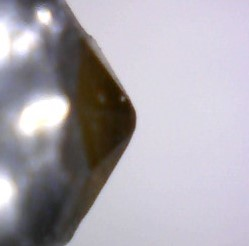

In [4]:
img_1 = cv.imread('../dataset/zoom_needle/b_needle_1.jpg', cv.IMREAD_GRAYSCALE)

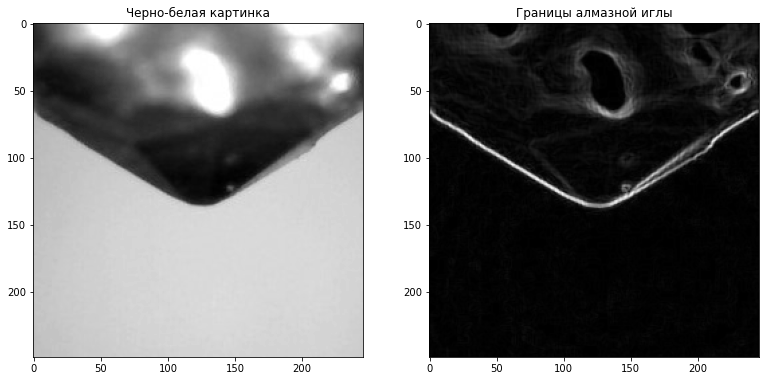

In [5]:
draw_borders(img_1)

### Пример 2

На фоне имеются другие объекты, цвет кончика иглы и фон находятся в одной цветовой гамме

<img src="../dataset/zoom_needle/b_needle_2.jpg" alt="затупленная игла с невыраженными границами" width="200"/>

In [6]:
img_2 = cv.imread('../dataset/zoom_needle/b_needle_2.jpg', cv.IMREAD_GRAYSCALE)

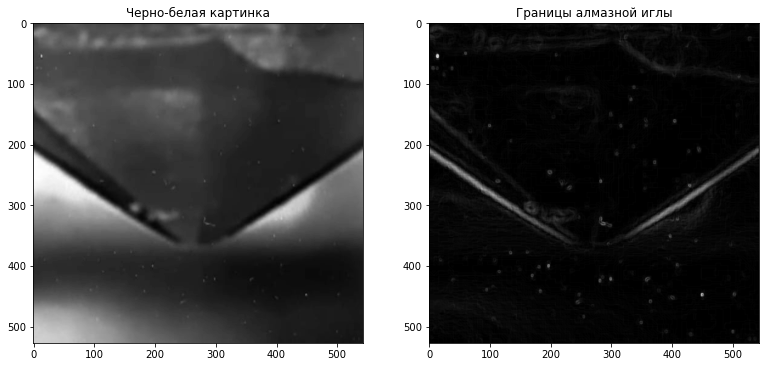

In [7]:
draw_borders(img_2)

#### Повышение контрастности ЧБ изображения
Попробуем улучшить результат работы фильтра, изменяя контрастность черно-белой картинки

In [8]:
def calc_gray_hist(img):
    """
    Функция для расчёта гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    grayHist = np.zeros([256], np.uint64)
    for i in range(height):
        for j in range(weight):
            grayHist[img[i][j]] += 1
    return grayHist

In [9]:
def gray_hist(img):
    """
    Функция для отрисовки гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    pixelSequence = img.reshape([height * weight, ])
    numberBins = 256
    histogram, bins, patch = plt.hist(pixelSequence, numberBins,
                                      facecolor='black', histtype='bar')
    plt.xlabel("gray label")
    plt.ylabel("number of pixels")
    plt.axis([0, 255, 0, np.max(histogram)])
    plt.show()

**1. Cпособ улучшения картинки**

***Нормализация гистограммы***

которая представляет собой метод линейного преобразования, который автоматически выбирает значения a и b, где

$a = \frac{O_{max}-O_{min}}{I_{max}-I_{min}},b=O_{min}-\frac{O_{max}-O_{min}}{I_{max}-I_{min}}*I_{min}$,

где 
- $O_{max},O_{min}$ - минимальный уровень серого и максимальный уровень серого, отображаемые в исходном изображении
- $I_{max},I_{min}$- минимальный уровень серого и максимальный уровень серого, заданный самостоятельно

*Замечание:*

Если $a > 1$, коэффициент контрастности выходного изображения увеличивается, если $0 < a < 1$, коэффициент контрастности уменьшается маленький. 

Изменение значения $b$ влияет на яркость выходного изображения. При $b > 0$ яркость увеличивается, а при $b < 0$ яркость уменьшается.

In [10]:
def normaliz_hist(img):
    """
    Функция для нормализации гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    i_min, i_max = cv.minMaxLoc(img)[:2]
    o_min, o_max = 0, 255
    
     # Рассчитать значения a и b
    a = float(o_max - o_min) / (i_max - i_min)
    b = o_min - a * i_min
    
    out = a * img + b
    out = out.astype(np.uint8)
    return out

**2. Cпособ улучшения картинки**

***Глобальное выравнивание гистограммы***

Реализация выравнивания гистограммы в основном делится на четыре этапа:
1. Рассчитайте гистограмму градаций серого изображения
2. Рассчитать кумулятивную гистограмму серой гистограммы
3. Соотношение между уровнем серого на входе и уровнем серого на выходе
4. Циклически выводить уровень серого каждого пикселя изображения в соответствии с соотношением отображения

Соотношение сопоставления:

$q=\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}*256-1$

Где q - выходной пиксель, а p - входной пиксель. 

Можно так понять, $\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}$

Этот термин эквивалентен гистограмме совокупной вероятности гистограммы градаций серого (в диапазоне от 0 до 1), а затем увеличивает диапазон до 0–255, чтобы получить пиксели выходного изображения.

In [11]:
def equal_hist(img):
    return cv.equalizeHist(img)

**3. Cпособ улучшения картинки**

***Адаптивная коррекция гистограммы с ограниченным контрастом***

Адаптивное выравнивание гистограммы сначала делит изображение на непересекающиеся региональные блоки, а затем выполняет выравнивание гистограммы для каждого блока отдельно. Очевидно, что при отсутствии шума гистограмма в градациях серого для каждой небольшой области будет ограничена небольшим диапазоном градаций серого, но при наличии шума после выполнения выравнивания гистограммы для каждого блока разделенной области, Шум будет усиливаться. 

Во избежание появления шума предлагается «Ограничение контраста» (Contrast Limiting). Если интервал гистограммы заранее превышает предварительно установленный «предел контраста», он будет обрезан, а затем обрезанная часть будет равномерно распределена между другими Бин, тем самым восстанавливая гистограмму. Далее вводится функция выравнивания адаптивной гистограммы для ограничения контраста, реализованная OpenCV,

In [12]:
def additive_correct(img):
    new_img = cv.resize(img, None, fx=0.5, fy=0.5)
     # Создать объект CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
     # Адаптивное пороговое выравнивание для ограничения контраста
    dst = clahe.apply(new_img)
    return dst

**1. Нормализация гистограммы**

*Пример 2*

In [13]:
img_2_normaliz = normaliz_hist(img_2)

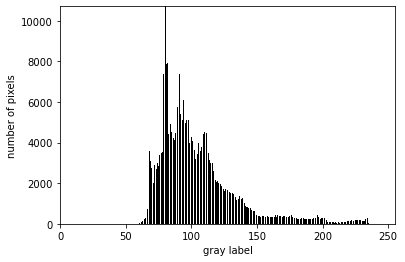

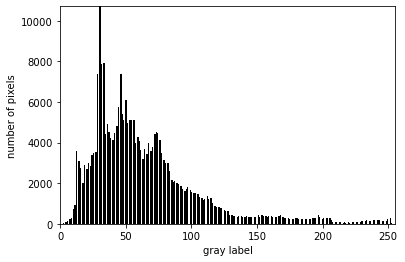

In [14]:
gray_hist(img_2)
gray_hist(img_2_normaliz)

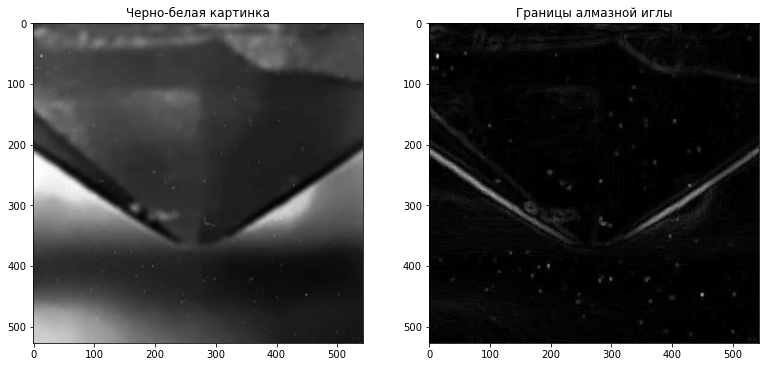

In [15]:
draw_borders(img_2_normaliz)

**2. Глобальное выравнивание гистограммы**

*Пример 2*

In [16]:
img_2_normaliz = equal_hist(img_2)

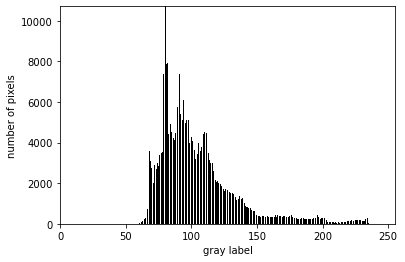

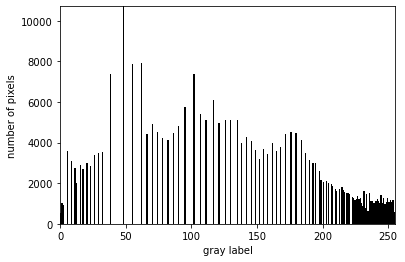

In [17]:
gray_hist(img_2)
gray_hist(img_2_normaliz)

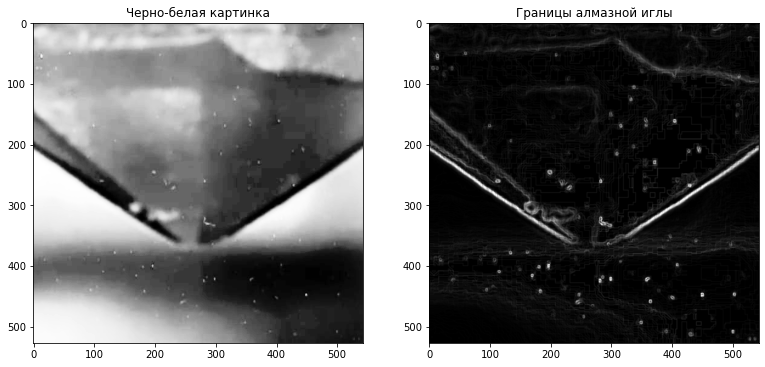

In [18]:
draw_borders(img_2_normaliz)

**3. Cпособ улучшения Адаптивная коррекция гистограммы с ограниченным контрастом**

*Пример 2*

In [19]:
img_2_dst = additive_correct(img_2)

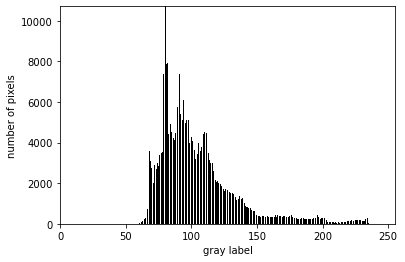

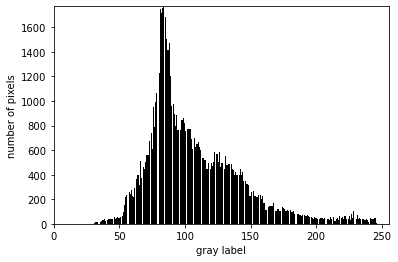

In [20]:
gray_hist(img_2)
gray_hist(img_2_dst)

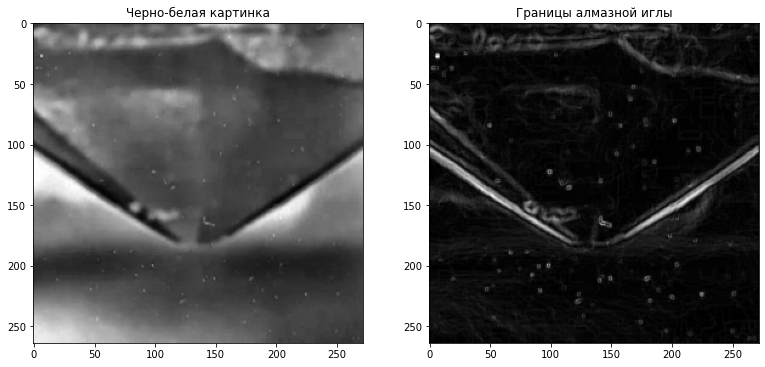

In [21]:
draw_borders(img_2_dst)

**4. Выполним два преобразования гистограммы - aдаптивное пороговое выравнивание для ограничения контраста и глобальное выравнивание гистограммы**

*Пример 2*

In [22]:
img_2_equal_dst = equal_hist(img_2_dst)

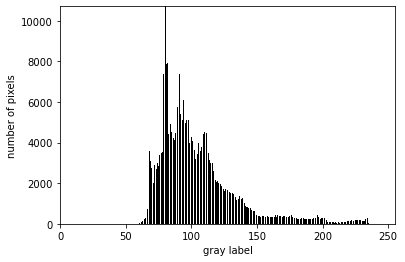

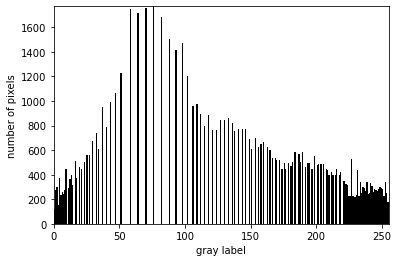

In [23]:
gray_hist(img_2)
gray_hist(img_2_equal_dst)

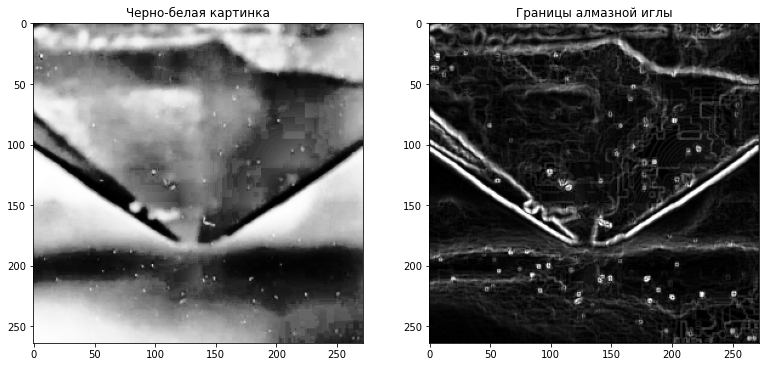

In [24]:
draw_borders(img_2_equal_dst)

## Пример 3

Кончик иглы на картинке просматривается плохо, а так же есть некоторые искревления в основании самой иглы

<img src="../dataset/zoom_needle/b_needle_7.jpg" alt="затупленная игла с невыраженными границами и имеет обточенные краями" width="200"/>

**1. Построение границ алмазной иглы без преобразований изображения**

In [25]:
img_3 = cv.imread('../dataset/zoom_needle/b_needle_7.jpg', cv.IMREAD_GRAYSCALE)

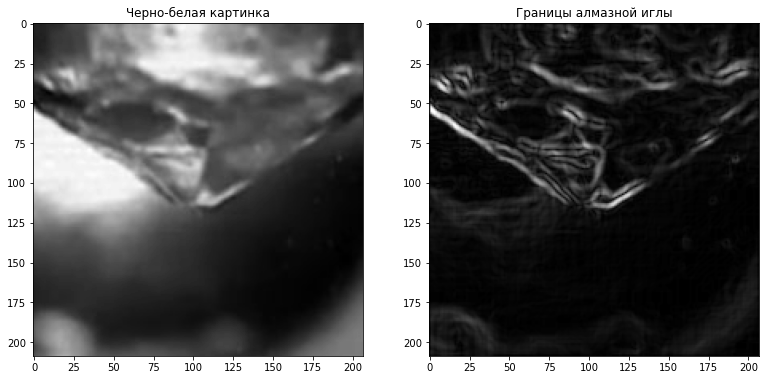

In [26]:
draw_borders(img_3)

*Попробуем улучшить результат, *

**1. Нормализация гистограммы**

*Пример 3*

In [27]:
img_3_normaliz = normaliz_hist(img_3)

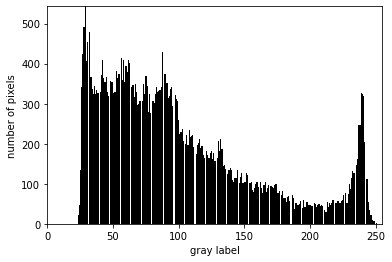

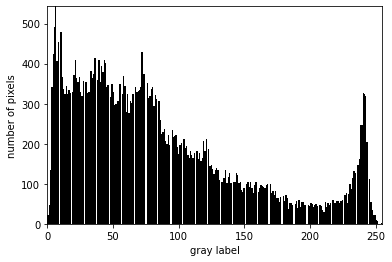

In [28]:
gray_hist(img_3)
gray_hist(img_3_normaliz)

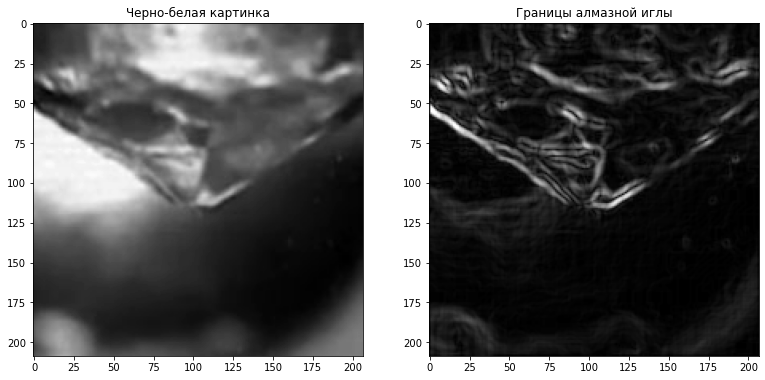

In [29]:
draw_borders(img_3_normaliz)

**2. Глобальное выравнивание гистограммы**

*Пример 3*

In [30]:
img_3_equal = equal_hist(img_3_normaliz)

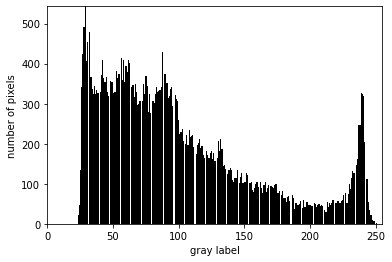

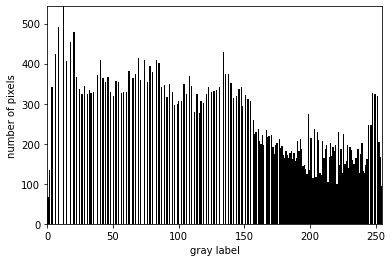

In [31]:
gray_hist(img_3)
gray_hist(img_3_equal)

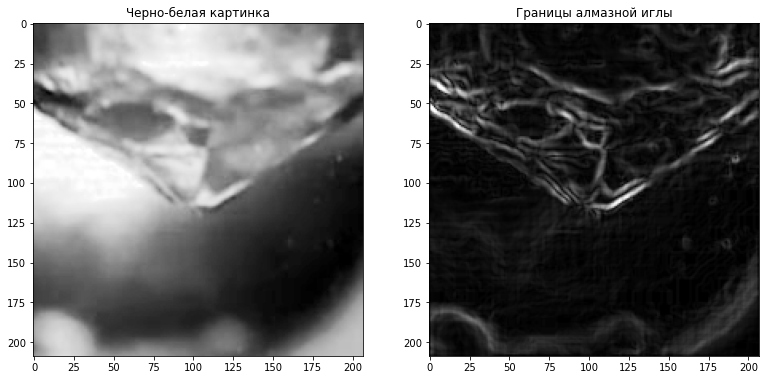

In [32]:
draw_borders(img_3_equal)

**3. Cпособ улучшения Адаптивная коррекция гистограммы с ограниченным контрастом**

*Пример 3*

In [33]:
img_3_dst = additive_correct(img_3)

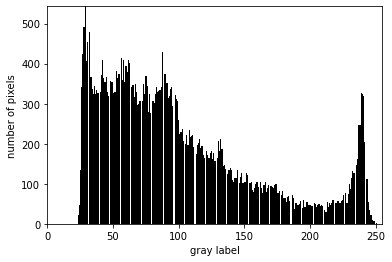

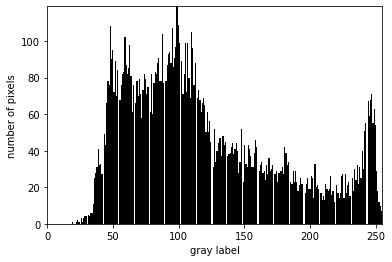

In [34]:
gray_hist(img_3)
gray_hist(img_3_dst)

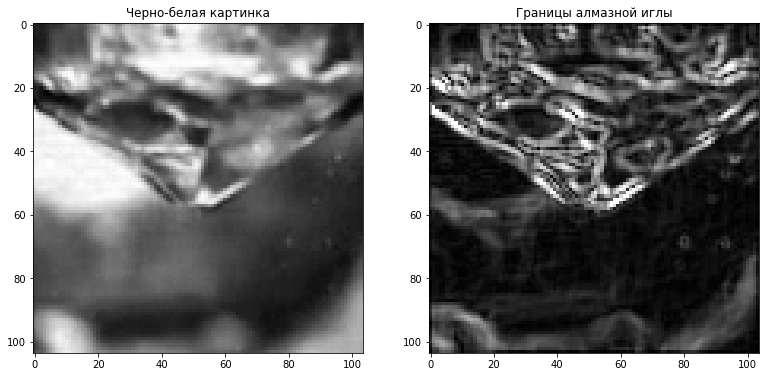

In [35]:
draw_borders(img_3_dst)

**4. Выполним два преобразования гистограммы - aдаптивное пороговое выравнивание для ограничения контраста и глобальное выравнивание гистограммы**

*Пример 2*

In [36]:
img_3_equal_dst = equal_hist(img_3_dst)

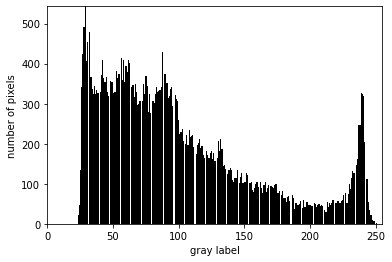

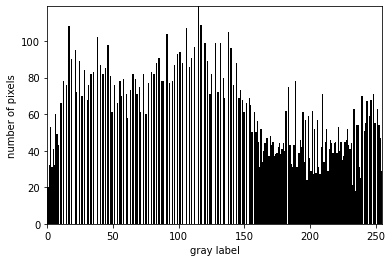

In [37]:
gray_hist(img_3)
gray_hist(img_3_equal_dst)

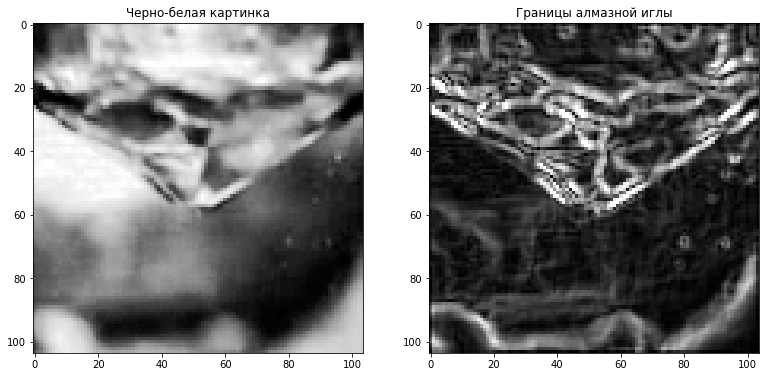

In [38]:
draw_borders(img_3_equal_dst)

Источники :
- [opencv/Sobel](https://github.com/arseny-emchik/opencv/blob/master/Sobel_Laplacian.md)
- [OpenCV: Sobel Derivatives](https://docs.opencv.org/4.5.3/d2/d2c/tutorial_sobel_derivatives.html)
- [Алгоритмы выделения контуров изображений / Хабр](https://habr.com/ru/post/114452/)
- [Оператор Собеля — Википедия](https://ru.wikipedia.org/wiki/Оператор_Собеля)